<a href="https://colab.research.google.com/github/SofiMich/DL/blob/main/Tarea2/T2_2_Michaelian_ConNextNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de edades usando bloques ConNext

En este ejercicio de la tarea vamos a entrenar modelos d regresion para predecir edades a partir de imágenes etiquetadas de rostros humanos. 
Nos vamos a basar en el notebook visto en clase para clasificar comida usando bloques ResNet y sustituir la arquitectura usando bloques ConvNext:

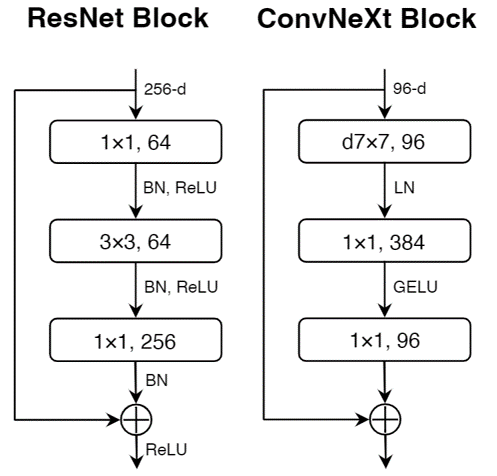

# 1 Preparación

## 1.1 Bibliotecas

In [1]:
# inspeccionar arquitecturas
!pip install torch-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take
# sistema de archivos
import os

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.models as tvm
from torchvision import transforms as T
from torchvision.ops import Permute

# imágenes
from skimage import io
from skimage.transform import resize
from PIL import Image

# inspeccion de la arquitectura
from torchsummary import summary

# barras de progreso
from tqdm.auto import trange
from tqdm.auto import tqdm

## 1.2 Auxiliares

In [3]:
# directorio de datos
URL = 'https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download'
base_dir = '../data/faces'
filename = 'UTKFace.tar.gz'
data_dir = '../data/faces/UTKFace'
filepath = os.path.join(base_dir, filename)

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la rejilla de imágenes
ROWS, COLS = 4, 8

# tamaño del conjunto de entrenamiento (porcentaje)
TRN_SIZE = 0.8
NUM_WORKERS = 4 # hilos

# media y varianza de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def crop_center(img, cropx, cropy):
    y, x = img.shape[:2]
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2    
    return img[starty:starty+cropy, startx:startx+cropx]

def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
  """Displays examples in a grid."""
  fig, ax = plt.subplots(rows, cols, figsize=figsize)
  i = 0
  for r in range(rows):
      for c in range(cols):
          ax[r, c].imshow(xs[i], cmap='gray')
          ax[r, c].set_title(titles[i])
          ax[r, c].set_xticklabels([])
          ax[r, c].set_yticklabels([])
          i += 1
  fig.tight_layout()
  plt.show()

def display_batch(x, titles, rows, cols, figsize=(12, 6)):
  """Despliega un lote en una cuadrícula."""
  # denormalizamos
  for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
      x[:, c] = x[:, c] * std + mean 
  x *= 255
  # rotamos canales
  x = x.permute(0, 2, 3, 1)
  # convertimos a entero
  x = (x.numpy()).astype(np.uint8)
  # desplegamos lote
  display_grid(x, titles, rows, cols, figsize)

def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def display_losses(losses):
  train_loss, test_loss = zip(*losses)
  plt.plot(train_loss,label='Entrenamiento')
  plt.plot(test_loss,label='Prueba')
  plt.xlabel('Época')
  plt.ylabel('Pérdida')
  plt.legend()
  plt.grid()
  plt.show()

def numpy_to_torch(x):
    x = T.functional.to_tensor(x)
    x = x.type(torch.float32)
    return x

# reproducibilidad
set_seed(42)

# 2 Datos

UTKFace (https://susanqq.github.io/UTKFace/) es un dataset con más de 20,000 imágenes de rostros de personas con edades, etnias y género distintos. Las edades están en un rango de entr 0 y 116 años, mientras que las etnias están etiquetadas como "blanco", "negro", "asiático", "indio" y "otros" (hispanos, latinos y de medio oriente) y los géneros como "femenino" y "masculino". Las imágenes cuentan con una gran diversidad de poses, expresiones faciales, fondos resolución, iluminación, etc.

## 2.1 Descarga de UTKFace

In [4]:
! mkdir -p {base_dir}
! wget -nc {URL} -O {filepath}
! tar -zxf {filepath} -C {base_dir}

--2022-11-14 05:26:14--  https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download
Resolving cloud.xibalba.com.mx (cloud.xibalba.com.mx)... 187.188.130.162
Connecting to cloud.xibalba.com.mx (cloud.xibalba.com.mx)|187.188.130.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106634631 (102M) [application/x-gzip]
Saving to: ‘../data/faces/UTKFace.tar.gz’

../data/faces/UTKFa 100%[===================>] 101.69M  5.87MB/s    in 20s     

2022-11-14 05:26:36 (5.00 MB/s) - ‘../data/faces/UTKFace.tar.gz’ saved [106634631/106634631]



El nombre de los archivos de la imagen contiene sus etiquetas en formato:
```
[edad]_[género]_[etnia]_[fecha y  hora].jpg
```
Como se muestra en el ejemplo:

In [5]:
! ls {data_dir} | head -1

100_0_0_20170112213500903.jpg.chip.jpg


#### Dividir los datos en entrenamiento y prueba

In [6]:
def dividirDatos(trn_size, root):
  imagenes = os.listdir(root)
  trn_size = int(trn_size * len(imagenes)) 
  tst_size = len(imagenes) - trn_size 
  trn_names = np.random.choice(imagenes,trn_size,replace=False)
  tst_names = list(set(imagenes)-set(trn_names))
  return trn_names, tst_names

In [7]:
trn_size = 0.8
trn_names, tst_names = dividirDatos(trn_size, data_dir)

## 2.3 Cargador de datos y exploración

In [8]:
class UTKFaceDS:

  def __init__(self, root, subset, trn_names, tst_names, transform=None):
    
    # guardamos la tranformación para las imágenes
    self.transform = transform

    # lista con las rutas a las imagenes
    self.paths = []
    # lista con las etiquetas de las imagenes
    self.labels = []

    # obtener la lista de nombres de las imágenes
    names = trn_names if subset == 'train' else tst_names
    
    # etiquetamos cada imagen con su edad
    for name in names:
      self.labels.append(name.split('_')[0]) # la edad es la primera parte del nombre de la imagen
      self.paths.append(f'{data_dir}/{name}') # agregamos la ruta de cada imagen

  # regresar un elemento
  def __getitem__(self, i):
    # obtenemos la ruta de la imagen
    path = self.paths[i]
    # cargamos de la imagen
    x = Image.open(path)
    # aplicamos la transformacion
    if self.transform is not None:
      x = self.transform(x)
    # leeamos la etiqueta
    y = np.array(self.labels[i], np.float32).reshape(1)
    # regresamos el ejemplo
    return x,y
  
  def __len__(self):
    # número de ejemplos en el conjunto
    return len(self.paths)

### 2.3.1 Conjunto de entrenamiento

Para el acreccentamiento de los datos de entrenamiento, vamos a usar una reflexión horizntal:

In [9]:
# Transformaciones de los datos
trn_tsfm = T.Compose([
    # --Acrecentamiento de datos con espejo horizontal--
    T.RandomHorizontalFlip(),
    # convertimos a torch.Tensor 
    T.ToTensor(),
    # Normalizamos
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

Tamaño del conjunto de entrenamiento: 18966


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


x shape=torch.Size([32, 3, 200, 200]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


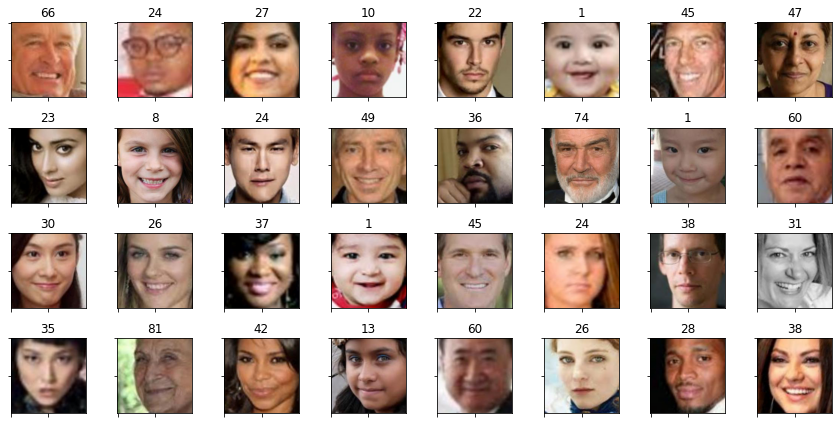

In [10]:
# conjunto de entrenamiento
trn_ds = UTKFaceDS(data_dir, 'train', trn_names, tst_names, transform=trn_tsfm)
print(f'Tamaño del conjunto de entrenamiento: {len(trn_ds)}')

# entrenamiento
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # numero de procesos paralelos
    num_workers=NUM_WORKERS
)

# desplegamos un lote de imágenes
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{int(l.item())}' for l in y]
display_batch(x, titles, ROWS, COLS)

### 2.3.2 Conjunto de prueba

Tamaño del conjunto de prueba: 4742
x shape=torch.Size([32, 3, 200, 200]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


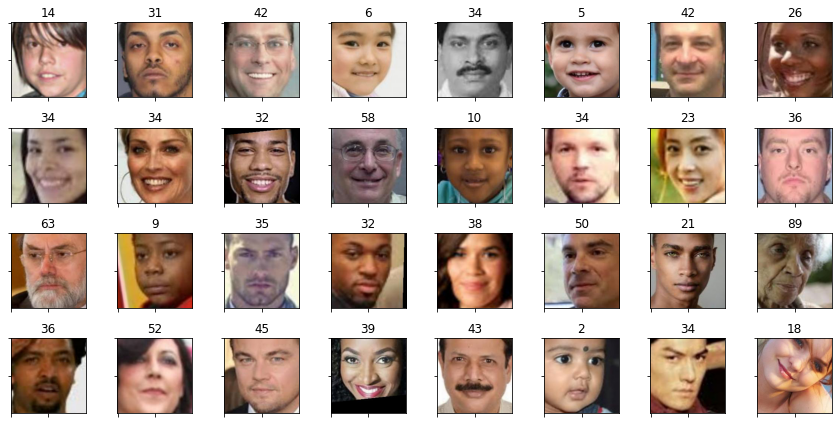

In [11]:
# Transformaciones para el conjunto de prueba
tst_tsfm = T.Compose([
    # convertimos a torch.Tensor
    T.ToTensor(),
    # Normalizamos
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# conjunto de prueba
tst_ds = UTKFaceDS(data_dir, 'test',trn_names, tst_names, transform=tst_tsfm)
print(f'Tamaño del conjunto de prueba: {len(tst_ds)}')

# entrenamiento
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # numero de procesos paralelos
    num_workers=NUM_WORKERS
)

# desplegamos un lote de imágenes
x, y = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{int(l.item())}' for l in y]
display_batch(x, titles, ROWS, COLS)

# 3 Modelo

## 3.1 Bloque ResNet --> bloque ConvNext

Vamos a modificar la arquitectura vista en clase sustituyendo los bloques ResNet con ConNeXt:

*   La primera modificación que haemos es la primera convolución, ahora usando un kernel de 7x7 y haciéndola en profundidad agrupando por el número de canales
*   La segunda modificación es la normalización por capa, que recibe el número de canales de entrada.
*   Agregamos también dos capas convolucionales intermedias.
*   Finalmente, la fución de activación es ahora una GELU.





In [12]:
class ConvNextBlock(nn.Module):

  def __init__(self,in_channels):
    super(ConvNextBlock, self).__init__()

    self.cnn_block = nn.Sequential(
        nn.Conv2d(
                in_channels, in_channels, kernel_size=7, padding=3, bias=False, groups=in_channels
            ),
            # Según https://towardsdatascience.com/implementing-convnext-in-pytorch-7e37a67abba6 es igual a LayerNorm para datos en 2D
            nn.GroupNorm(num_groups=1, num_channels=in_channels),
            nn.Conv2d(in_channels, in_channels, kernel_size=1),
            nn.GELU(),
            nn.Conv2d(in_channels, in_channels, kernel_size=1),
    )

  def forward(self, x):
    x1 = self.cnn_block(x)
    x = x1 + x
    return x

In [13]:
model_convnxt_block = ConvNextBlock(3)
summary(model_convnxt_block, (3, 200, 200), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 200, 200]         --
|    └─Conv2d: 2-1                       [-1, 3, 200, 200]         147
|    └─GroupNorm: 2-2                    [-1, 3, 200, 200]         6
|    └─Conv2d: 2-3                       [-1, 3, 200, 200]         12
|    └─GELU: 2-4                         [-1, 3, 200, 200]         --
|    └─Conv2d: 2-5                       [-1, 3, 200, 200]         12
Total params: 177
Trainable params: 177
Non-trainable params: 0
Total mult-adds (M): 6.60
Input size (MB): 0.46
Forward/backward pass size (MB): 3.66
Params size (MB): 0.00
Estimated Total Size (MB): 4.12

In [14]:
x = torch.zeros(1, 3, 200, 200)
y = model_convnxt_block(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 200, 200]) => torch.Size([1, 3, 200, 200])


## 3.2 Modificación de la arquitectura ResNet --> ConvNext

Ahora vamos a modificar la arquitectura original cambiando los bloqes ReNet por bloques ConvNext:

In [15]:
class ConvNextNet(nn.Module):

  def __init__(self,dim):
    super(ConvNextNet, self).__init__()

    self.num_features = 3 * 100 * 100

    self.cnn = nn.Sequential(
        ConvNextBlock(dim),
        nn.MaxPool2d(kernel_size=2, stride=2),     
    )

    self.flatten = nn.Flatten()
    self.reg = nn.Linear(self.num_features,1)

  def forward(self, x):
    x = self.cnn(x)
    x = self.flatten(x)
    x = self.reg(x)
    return x

In [16]:
model_cvn = ConvNextNet(3)
summary(model_cvn, (3, 200, 200), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 100, 100]         --
|    └─ConvNextBlock: 2-1                [-1, 3, 200, 200]         --
|    |    └─Sequential: 3-1              [-1, 3, 200, 200]         177
|    └─MaxPool2d: 2-2                    [-1, 3, 100, 100]         --
├─Flatten: 1-2                           [-1, 30000]               --
├─Linear: 1-3                            [-1, 1]                   30,001
Total params: 30,178
Trainable params: 30,178
Non-trainable params: 0
Total mult-adds (M): 6.63
Input size (MB): 0.46
Forward/backward pass size (MB): 3.66
Params size (MB): 0.12
Estimated Total Size (MB): 4.24

In [17]:
x = torch.zeros(1, 3, 200, 200)
y = model_cvn(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 200, 200]) => torch.Size([1, 1])


## 3.2 Transferencia de conocimiento

Para esta parte voy a usar squeezenet:

In [18]:
tvm.squeezenet1_0()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [19]:
class TransferModel(nn.Module):
  def __init__(self, pretrained):
    super(TransferModel, self).__init__()

    # cargamos del modelo
    self.cnn = tvm.squeezenet1_0(pretrained=pretrained)
    # reemplazarmos la FC
    self.cnn.fc = nn.Identity()
    in_features = 1000 
    # Regresión
    self.reg = nn.Sequential(
        nn.BatchNorm1d(in_features),
        nn.Linear(in_features,1)
    )
  
  def forward(self, x):
    x = self.cnn(x)
    x = self.reg(x)
    return x

  # Para congelar algunos parámetros
  def freeze_features(self,freeze=True):
    requires_grad = not freeze
    for param in self.cnn.parameters():
      param.requires_grad = requires_grad

model_tf = TransferModel(pretrained=True)
# congelamos parámetros
model_tf.freeze_features()
# modo de evaluación
_ = model_tf.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

In [20]:
x = torch.zeros(1, 3, 200, 200)
y = model_tf(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 200, 200]) => torch.Size([1, 1])


In [21]:
summary(model_tf, (3, 200, 200), device='cpu', verbose = 0)

Layer (type:depth-idx)                   Output Shape              Param #
├─SqueezeNet: 1-1                        [-1, 1000]                --
|    └─Sequential: 2-1                   [-1, 512, 12, 12]         --
|    |    └─Conv2d: 3-1                  [-1, 96, 97, 97]          (14,208)
|    |    └─ReLU: 3-2                    [-1, 96, 97, 97]          --
|    |    └─MaxPool2d: 3-3               [-1, 96, 48, 48]          --
|    |    └─Fire: 3-4                    [-1, 128, 48, 48]         (11,920)
|    |    └─Fire: 3-5                    [-1, 128, 48, 48]         (12,432)
|    |    └─Fire: 3-6                    [-1, 256, 48, 48]         (45,344)
|    |    └─MaxPool2d: 3-7               [-1, 256, 24, 24]         --
|    |    └─Fire: 3-8                    [-1, 256, 24, 24]         (49,440)
|    |    └─Fire: 3-9                    [-1, 384, 24, 24]         (104,880)
|    |    └─Fire: 3-10                   [-1, 384, 24, 24]         (111,024)
|    |    └─Fire: 3-11                   

# 4 Entrenamiento

In [22]:
! nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [23]:
# obtenemos dispositivo en gpu, si no en cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [24]:
def train_epoch(data_loader,model,opt,epoch):
  # para cada lote
  for x, y_true in data_loader:
    x = x.to(device)
    y_true = y_true.to(device)
    # inferencia
    y_hat = model(x)
    loss = F.mse_loss(y_hat, y_true)
    # backprop
    opt.zero_grad() # vaciamos los gradientes
    loss.backward() # retropropagamos
    opt.step() # actualizamos parámetros

def eval_epoch(data_loader, model, epoch):
  # Para la evaluación evitamos que se regsitren las operaciones
  with torch.no_grad():
    
    losses = []
    
    for x, y_true in data_loader:
      x = x.to(device)
      y_true = y_true.to(device)
      y_hat = model(x) # Evaluamos
      loss_b = F.mse_loss(y_hat, y_true) # Calculamos la pérdida
      losses.append(loss_b.item())
    
    loss = np.mean(losses)
    return loss

def train(model, train_dl, test_dl,epochs=10,lr=1e-3,opt='Adam',
          transfer_learning = False,full_train=False,
          L2lambda=0,progress=True):
  
  model = model.to(device)
  loss_hist = []

  # optimizadores
  if opt == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=L2lambda)
  if opt == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(),lr=lr, weight_decay=L2lambda)
  if opt == 'Adam':
    optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=L2lambda)

  # Congelamos loss parámetros
  if transfer_learning:
    freeze = not full_train # si no se quiere reentrenar toda la red, se congelan los parametros
    model.freeze_features(freeze)

  # Para imprimir el progreso
  range_progress = trange(epochs)  if progress else range(epochs)

  model.eval()

  # ciclo de entrenamiento
  for epoch in range_progress:
    # Entrenamiento
    model.train()
    train_epoch(train_dl,model,optimizer,epoch)

    # Evaluación
    model.eval()
    train_loss = eval_epoch(train_dl, model, epoch)
    test_loss = eval_epoch(test_dl, model, epoch)
  
    loss_hist.append([train_loss,test_loss])

    if progress:
      print(f'E{epoch:02} '
            f'loss=[{train_loss:6.2f},{test_loss:6.2f}]')
      
  return loss_hist

## 4.1 Entrenamiento del modelo con arquitectura ResNet con bloques ConNeXt

In [ ]:
loss_cvn = train(model_cvn, trn_dl, tst_dl,epochs=20,lr=1e-3,opt='Adam',
          transfer_learning = False,progress=True)

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[221.31,229.77]
E01 loss=[224.38,242.50]
E02 loss=[189.76,205.82]


In [ ]:
display_losses(loss_cvn)

Hasta la época 150 no ha ocurrido que la red sobreajuste, sin embargo se observa una tendencia a disminuir la pendiente, lo que puede indicar que el modelo está llegando a su límite. En ambos conjuntos se tiene un comportamiento (hasta el momento) decente, aunque parece que la curva de prueba podría empezar a subir.

In [ ]:
def evaluation(dl,model):
  model.to(device).eval()
  with torch.no_grad():
    x, y_true = next(iter(dl))
    y_pred = model(x.to(device))
    titles = []
    for i in range(len(y_true)):
      titles.append(f'y={int(y_true[i].item())},y_h={int(y_pred[i].item())}')
    display_batch(x, titles, ROWS, COLS)

Podemos observar algunos de los ejemplos evaluados:

In [ ]:
evaluation(tst_dl, model_cvn)

Podemos observar que algunos de los errores cometidos por la red son, dentro de lo ue cabe "razonables", como es el caso de la chica de 18 años del último renglón, al igual que algunas fotos en las que el desenfoque termina hciendo un efecto de suavizado a la piel o algunas personas en donde la edad calculada es muy cercana a la real. También existen otros "errores" que sí son "graves", como es el caso de la mujer de 85 años de la última cuya edad calculada fue de 52.  

## 4.2 Entrenamiento con transferencia de conocimiento, reentrenando solo la última capa

In [ ]:
losses_tf_freeze = train(model_tf, trn_dl, tst_dl, epochs=10, lr=1e-3, opt='Adam',
          transfer_learning = True, full_train=False, progress=True)

In [ ]:
display_losses(losses_tf_freeze)

In [ ]:
evaluation(tst_dl, model_tf)

Observamos que para este modelo preentrenado la pérdia ha disminuido en tan solo 8 épocas lo que nuestro modelo ha logrado en el doble de épocas. Sin embargo, el comportamiento en el conjnto de prueba nos sugiere que deberíamos usar una tasa de aprendizaje más baja.

## 4.3 Entrenamiento con transferencia de conocimiento, reentrenando toda la red

In [ ]:
losses_tf_full = train(model_tf, trn_dl, tst_dl,epochs=10,lr=1e-3,opt='Adam',
          transfer_learning = True,full_train=True,progress=True)

In [ ]:
display_losses(losses_tf_full)